In [1]:
import numpy as np
from rubin_sim.maf import BaseMetric

import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import rubin_sim.maf as maf
import rubin_sim.utils as rsUtils
from rubin_sim.data import get_baseline
import os
import pandas as pd

In [2]:
baseline_file = get_baseline()
name = os.path.basename(baseline_file).replace('.db','')
out_dir = 'temp'
results_db = maf.db.ResultsDb(out_dir=out_dir)


In [3]:
# healpix resolution. Turing down a little to speed things up
nside = 64

bundle_list = []
time_points = np.arange(0,3652+365.25, 365.25)


for filtername in 'ugrizy':
    metric = maf.AccumulateM5Metric(time_points)
    # only use given filter. Toss out short visits and ToO visits
    sql = "filter='%s' and visitexposuretime > 17 and scheduler_note not like '%%ToO%%'" % filtername
    slicer = maf.slicers.HealpixSlicer(nside=nside)
    bundle_list.append(maf.MetricBundle(metric, slicer, sql, run_name=name))


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [4]:
bd = maf.metricBundles.make_bundles_dict_from_list(bundle_list)
bg = maf.metricBundles.MetricBundleGroup(bd, baseline_file, out_dir=out_dir, results_db=results_db)
bg.run_all()

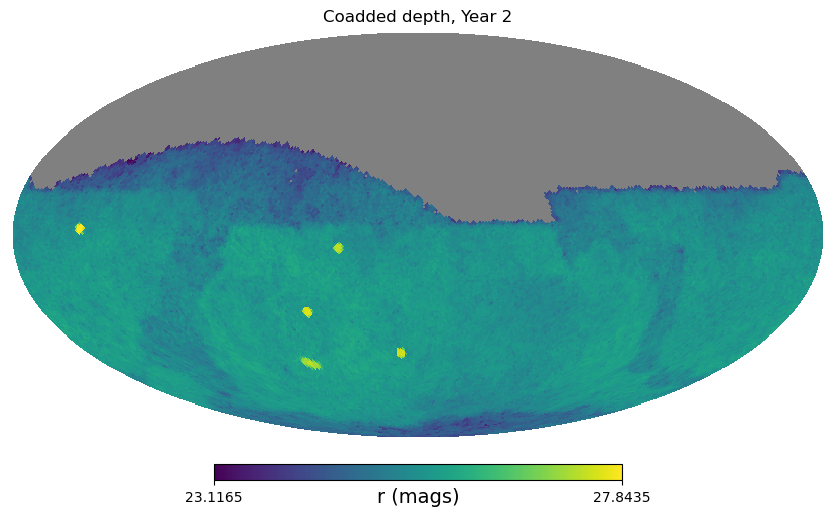

In [7]:
# Now we have the coaded depth maps at 10 time steps. 
i = 1
hp.mollview(bd['baseline_v4_3_1_10yrs_AccumulateM5Metric_r_and_visitexposuretime_gt_17_and_scheduler_note_not_like_ToO_HEAL'].metric_values[:,i], title="Coadded depth, Year %i" % (i),
           unit="r (mags)")

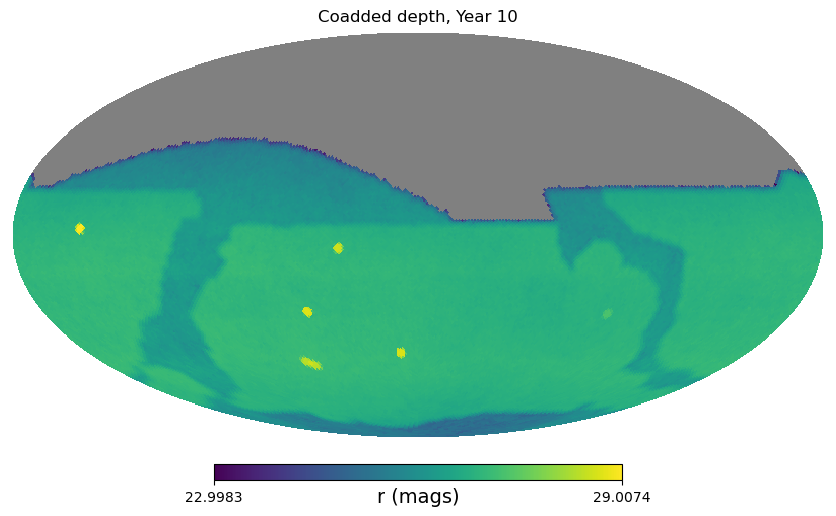

In [8]:
i=10
hp.mollview(bd['baseline_v4_3_1_10yrs_AccumulateM5Metric_r_and_visitexposuretime_gt_17_and_scheduler_note_not_like_ToO_HEAL'].metric_values[:,i], title="Coadded depth, Year %i" % (i),
           unit="r (mags)")

In [11]:
# loop over filter and times to make a table of the median values
df = pd.DataFrame()
for filtername in 'ugrizy':
    medians = []
    maps = bd["baseline_v4_3_1_10yrs_AccumulateM5Metric_%s_and_visitexposuretime_gt_17_and_scheduler_note_not_like_ToO_HEAL" % filtername].metric_values
    # doing a stupid loop because masked values are a pain
    for i in np.arange(11):
        medians.append(np.median(maps[:,i].data[~maps[:,i].mask]))
    df[filtername] = medians
    

In [12]:
print("Median coadded depth per year per filter")
df

Median coadded depth per year per filter


,u,g,r,i,z,y
0,NaN,24.179770,24.160652,NaN,NaN,NaN
1,24.449404,25.507502,25.507295,25.092876,24.419967,23.530111
2,24.665816,25.913628,25.986721,25.501420,24.802669,23.911357
3,24.840406,26.104392,26.206515,25.727335,25.055232,24.138726
4,24.989072,26.216476,26.341968,25.860131,25.217357,24.282075
5,25.143859,26.323323,26.463279,25.972618,25.326040,24.386161
6,25.247444,26.397016,26.551352,26.067166,25.424044,24.473594
7,25.337808,26.489626,26.637233,26.149655,25.512441,24.552987
8,25.402292,26.554155,26.696414,26.206776,25.567130,24.607855
9,25.463136,26.623540,26.765361,26.269934,25.633000,24.675933


In [13]:
# say we want to do a single point:
bundle_list = []
time_points = np.arange(0,3652+365.25, 365.25)

# My favorite test sample point
ra = 0.
dec = -20.

for filtername in 'ugrizy':
    metric = maf.AccumulateM5Metric(time_points)
    # only use given filter. Toss out short visits and ToO visits
    sql = "filter='%s' and visitexposuretime > 17 and scheduler_note not like '%%ToO%%'" % filtername
    slicer = maf.slicers.UserPointsSlicer(ra=ra, dec=dec)
    bundle_list.append(maf.MetricBundle(metric, slicer, sql, run_name=name))


In [14]:
bd = maf.metricBundles.make_bundles_dict_from_list(bundle_list)
bg = maf.metricBundles.MetricBundleGroup(bd, baseline_file, out_dir=out_dir, results_db=results_db)
bg.run_all()

In [17]:
# load the results into a dataframe for pretty printing
df = pd.DataFrame()
for filtername,key in zip('ugrizy', bd):
    df[filtername] = np.concatenate([bd[key].metric_values.data.ravel()])


In [18]:
# depth at our sample point per year per filter. 
print("Coadded depths per year at ra=%.2f,dec=%.2f" % (ra, dec))
df

Coadded depths per year at ra=0.00,dec=-20.00


,u,g,r,i,z,y
0,-666.000000,-666.000000,-666.000000,-666.000000,-666.000000,-666.000000
1,24.576400,25.709689,25.656992,25.261662,24.646422,23.864157
2,24.620391,25.844772,25.893333,25.399709,24.809421,24.090185
3,24.877387,26.030537,26.264749,25.713258,24.993786,24.259525
4,25.008142,26.317575,26.459396,25.870088,25.215139,24.442310
5,25.039510,26.383530,26.526051,25.950262,25.277718,24.493098
6,25.270866,26.459872,26.637422,26.084294,25.422859,24.547168
7,25.375929,26.606595,26.737278,26.213451,25.550824,24.621244
8,25.383004,26.606595,26.765876,26.239988,25.562844,24.637563
9,25.459926,26.681425,26.837912,26.321372,25.635082,24.737146
